In [1]:

import concurrent.futures
import requests
import zipfile
import os
!pip install wget
import wget

link_train="https://zenodo.org/records/5706578/files/Train.zip?download=1"
link_val="https://zenodo.org/records/5706578/files/Val.zip?download=1"
link_test="https://zenodo.org/records/5706578/files/Test.zip?download=1"


def download_and_extract(url, destination):
  """Downloads a zip file from a URL and extracts it to a destination directory.

  Args:
    url: The URL of the zip file.
    destination: The directory to extract the zip file to.
  """

  # Download the zip file
  wget.download(url, out=destination+".zip")

  # Extract the zip file
  with zipfile.ZipFile(destination+".zip", 'r') as zip_ref:
    zip_ref.extractall(destination)

  print(f"Downloaded and extracted {url} to {destination}")

# Download and extract the train, validation, and test datasets in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(download_and_extract, link_train, 'Train'),
        executor.submit(download_and_extract, link_val, 'Val'),
        executor.submit(download_and_extract, link_test, 'Test')
    ]

    # Wait for all downloads and extractions to complete
    concurrent.futures.wait(futures)




  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=93b350524b3eea7093239a829772f2b6d28a49e0ce254d42b3f19e97e3193fb0
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Downloaded and extracted https://zenodo.org/records/5706578/files/Val.zip?download=1 to Val
Downloaded and extracted https://zenodo.org/records/5706578/files/Train.zip?download=1 to Train
Downloaded and extracted https://zenodo.org/records/5706578/files/Test.zip?download=1 to Test


In [48]:
!pip install segmentation-models-pytorch
!pip install timm
!pip install ptflops

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from collections import OrderedDict
from tqdm import tqdm
from ptflops import get_model_complexity_info
import segmentation_models_pytorch.utils


image_dir = os.path.join("./Train" ,"Train", "Rural", "images_png")
mask_dir = os.path.join("./Train" ,"Train", "Rural", "masks_png")

image_dir_val = os.path.join("./Val" ,"Val", "Rural", "images_png")
mask_dir_val = os.path.join("./Val" ,"Val", "Rural", "masks_png")


Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([7, 256, 256])


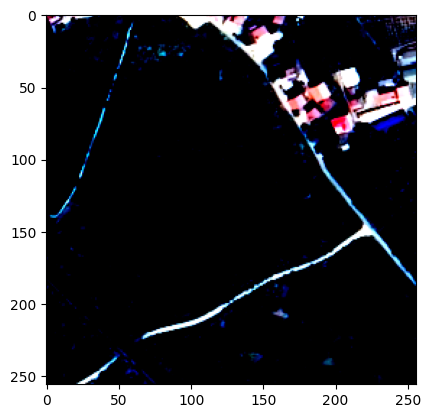

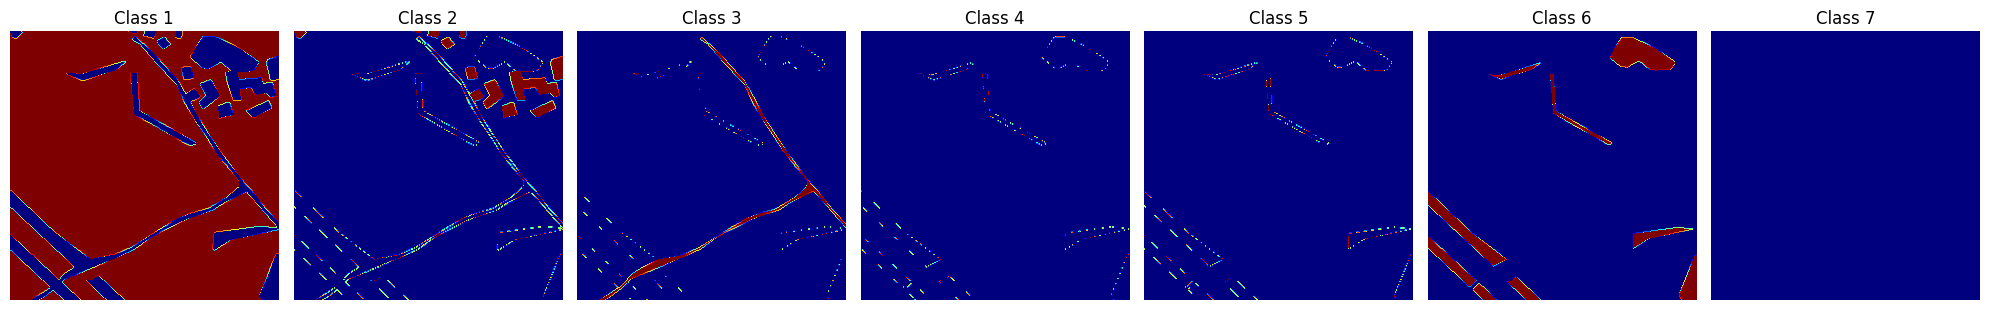

In [49]:


# Example grayscale values
COLOR_MAP = {
    'class1': 0.00392157,
    'class2': 0.00784314,
    'class3': 0.01176471,
    'class4': 0.01568628,
    'class5': 0.01960784,
    'class6': 0.02352941,
    'class7': 0.02745098
}

# Map class names to indices
LABEL_MAP = {k: v for v, k in enumerate(COLOR_MAP.keys())}

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    """
    Converts a grayscale mask to a one-hot encoded mask based on a color map and tolerance.

    Args:
        mask (np.ndarray): The input grayscale mask.
        label_map (dict): A dictionary mapping class names to label indices.
        tolerance (float): The tolerance for matching grayscale values.
        num_classes (int): Number of classes (channels).

    Returns:
        torch.Tensor: The one-hot encoded mask.
    """
    mask = np.asarray(mask, dtype=np.float32)
    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        # print(class_index, np.squeeze(matches, axis=0))
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Dataset class
class LoveDADataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

# Transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda mask: color_to_one_hot(mask, LABEL_MAP)),
])

# Dataset and DataLoaders
train_dataset = LoveDADataset(image_dir, mask_dir, image_transform, mask_transform)
val_dataset = LoveDADataset(image_dir_val, mask_dir_val, image_transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=1, pin_memory=True)

# Model definition

image, mask = dataset[13]
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")


plt.imshow(image.permute(1, 2, 0))
plt.show()

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

# Itera attraverso i canali della maschera (7 classi)
for i in range(7):
    # Estrai il canale i-esimo
    mask_class = mask[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

    # Visualizza la maschera della classe i
    axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
    axes[i].set_title(f'Class {i + 1}')
    axes[i].axis('off')  # Disabilita gli assi

# Mostra il risultato
plt.tight_layout()
plt.show()


In [31]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy

In [50]:
#deeplabv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics import JaccardIndex
# from numba import cuda


import numpy as np
import cv2
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import os
from PIL import Image

# --- Model Definition ---
class DeepLabV2(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV2, self).__init__()
        # Load the pre-trained ResNet-101 backbone
        resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)

        # Remove the fully connected layer of ResNet-101
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # ASPP (Atrous Spatial Pyramid Pooling) module
        self.aspp = nn.Sequential(
            ASPP(2048, [6, 12, 18, 24], 256),  # Output channels are 256
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.backbone(x)
        x = self.aspp(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=True)

        return x

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        for rate in atrous_rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


# --- Training (Optional) ---
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # print(f"Output shape: {outputs.shape}")
            # print(f"Mask shape: {masks.shape}")
            # print(f"Images shape: {images.shape}")


            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        miou = evaluate(model, val_loader, device, NUM_CLASSES)
        print(f'mIoU: {np.mean(miou):.4f}')

def evaluate(model, data_loader, device, num_classes):
    model.eval()
    total_iou = []
    val_loss = 0.0
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            val_loss += loss.item()
            # _, preds = torch.max(outputs, dim=1)
            preds = outputs.argmax(dim=1).detach()  # Detach to prevent GPU memory buildup
            masks = masks.argmax(dim=1).detach()
            for i in range(num_classes):
                intersection[i] += torch.sum((preds == i) & (masks == i)).float()
                union[i] += torch.sum((preds == i) | (masks == i)).float()

            # Free GPU memory
            del outputs, preds, masks,images
            torch.cuda.empty_cache()

    avg_val_loss = val_loss / len(data_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Calculate mIoU
    IoU = intersection / (union + 1e-6)  # Avoid division by zero
    # mIoU = IoU.mean()
    return IoU.data.cpu().numpy()

# --- Main ---
if __name__ == "__main__":
    # Hyperparameters
    NUM_CLASSES = 7  # Example: Pascal VOC has 21 classes (including background)
    BATCH_SIZE = 4
    LEARNING_RATE = 0.00009
    NUM_EPOCHS = 20

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model
    model = DeepLabV2(num_classes=NUM_CLASSES).to(device)


    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train(model, train_loader, criterion, optimizer, device, num_epochs=NUM_EPOCHS)
    # Training (optional)
    iou = evaluate(model, val_loader, device, NUM_CLASSES)
    # Evaluation
    print(f'IoU: {(iou)}')
    print(f'mean IoU: {np.mean(iou)}')



    # Save the model (optional)
    torch.save(model.state_dict(), 'deeplabv2_resnet101.pth')


100%|██████████| 342/342 [01:44<00:00,  3.26it/s]


Epoch 1/20, Loss: 1.0905


100%|██████████| 248/248 [01:02<00:00,  3.96it/s]


Validation Loss: 0.0000
mIoU: 0.2734


100%|██████████| 342/342 [01:44<00:00,  3.28it/s]


Epoch 2/20, Loss: 0.8850


100%|██████████| 248/248 [01:03<00:00,  3.93it/s]


Validation Loss: 0.0000
mIoU: 0.2365


100%|██████████| 342/342 [01:37<00:00,  3.50it/s]


Epoch 3/20, Loss: 0.7902


100%|██████████| 248/248 [01:07<00:00,  3.70it/s]


Validation Loss: 0.0000
mIoU: 0.3045


100%|██████████| 342/342 [01:38<00:00,  3.48it/s]


Epoch 4/20, Loss: 0.7519


100%|██████████| 248/248 [01:02<00:00,  3.97it/s]


Validation Loss: 0.0000
mIoU: 0.3081


100%|██████████| 342/342 [01:37<00:00,  3.52it/s]


Epoch 5/20, Loss: 0.6948


100%|██████████| 248/248 [01:04<00:00,  3.87it/s]


Validation Loss: 0.0000
mIoU: 0.3014


100%|██████████| 342/342 [01:36<00:00,  3.54it/s]


Epoch 6/20, Loss: 0.6817


100%|██████████| 248/248 [01:03<00:00,  3.93it/s]


Validation Loss: 0.0000
mIoU: 0.2719


100%|██████████| 342/342 [01:37<00:00,  3.50it/s]


Epoch 7/20, Loss: 0.6324


100%|██████████| 248/248 [01:02<00:00,  3.95it/s]


Validation Loss: 0.0000
mIoU: 0.2857


100%|██████████| 342/342 [01:37<00:00,  3.52it/s]


Epoch 8/20, Loss: 0.5768


100%|██████████| 248/248 [01:03<00:00,  3.88it/s]


Validation Loss: 0.0000
mIoU: 0.3155


100%|██████████| 342/342 [01:37<00:00,  3.53it/s]


Epoch 9/20, Loss: 0.5470


100%|██████████| 248/248 [01:03<00:00,  3.93it/s]


Validation Loss: 0.0000
mIoU: 0.3267


100%|██████████| 342/342 [01:37<00:00,  3.52it/s]


Epoch 10/20, Loss: 0.4887


100%|██████████| 248/248 [01:02<00:00,  3.98it/s]


Validation Loss: 0.0000
mIoU: 0.3126


100%|██████████| 342/342 [01:38<00:00,  3.48it/s]


Epoch 11/20, Loss: 0.4741


100%|██████████| 248/248 [01:03<00:00,  3.90it/s]


Validation Loss: 0.0000
mIoU: 0.2926


100%|██████████| 342/342 [01:38<00:00,  3.49it/s]


Epoch 12/20, Loss: 0.4629


100%|██████████| 248/248 [01:02<00:00,  3.97it/s]


Validation Loss: 0.0000
mIoU: 0.3138


100%|██████████| 342/342 [01:37<00:00,  3.52it/s]


Epoch 13/20, Loss: 0.4479


100%|██████████| 248/248 [01:03<00:00,  3.89it/s]


Validation Loss: 0.0000
mIoU: 0.3342


100%|██████████| 342/342 [01:36<00:00,  3.54it/s]


Epoch 14/20, Loss: 0.4334


100%|██████████| 248/248 [01:03<00:00,  3.91it/s]


Validation Loss: 0.0000
mIoU: 0.3087


100%|██████████| 342/342 [01:37<00:00,  3.52it/s]


Epoch 15/20, Loss: 0.4181


100%|██████████| 248/248 [01:02<00:00,  3.96it/s]


Validation Loss: 0.0000
mIoU: 0.3281


100%|██████████| 342/342 [01:37<00:00,  3.50it/s]


Epoch 16/20, Loss: 0.4090


100%|██████████| 248/248 [01:03<00:00,  3.92it/s]


Validation Loss: 0.0000
mIoU: 0.3127


100%|██████████| 342/342 [01:36<00:00,  3.56it/s]


Epoch 17/20, Loss: 0.5618


100%|██████████| 248/248 [01:02<00:00,  3.94it/s]


Validation Loss: 0.0000
mIoU: 0.3040


100%|██████████| 342/342 [01:37<00:00,  3.51it/s]


Epoch 18/20, Loss: 0.4131


100%|██████████| 248/248 [01:02<00:00,  3.99it/s]


Validation Loss: 0.0000
mIoU: 0.3159


100%|██████████| 342/342 [01:36<00:00,  3.54it/s]


Epoch 19/20, Loss: 0.4340


100%|██████████| 248/248 [01:03<00:00,  3.88it/s]


Validation Loss: 0.0000
mIoU: 0.3245


100%|██████████| 342/342 [01:37<00:00,  3.52it/s]


Epoch 20/20, Loss: 0.4072


100%|██████████| 248/248 [01:02<00:00,  3.97it/s]


Validation Loss: 0.0000
mIoU: 0.3204


100%|██████████| 248/248 [01:03<00:00,  3.90it/s]


Validation Loss: 0.0000
IoU: [0.45379692 0.31175447 0.08664531 0.4612361  0.10841636 0.25179467
 0.5689296 ]
mean IoU: 0.32036763429641724



Random Sample (Epoch 6)
Input Tensor:  torch.Size([1, 3, 256, 256])
Ground Truth:  torch.Size([7, 256, 256])
Model Output:  torch.Size([1, 7, 256, 256])


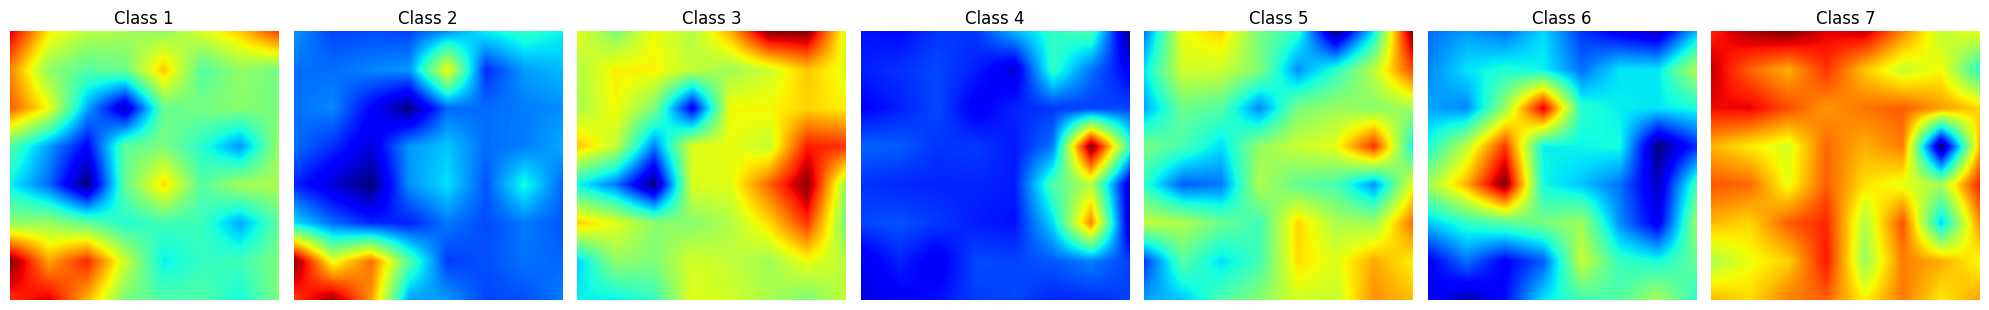

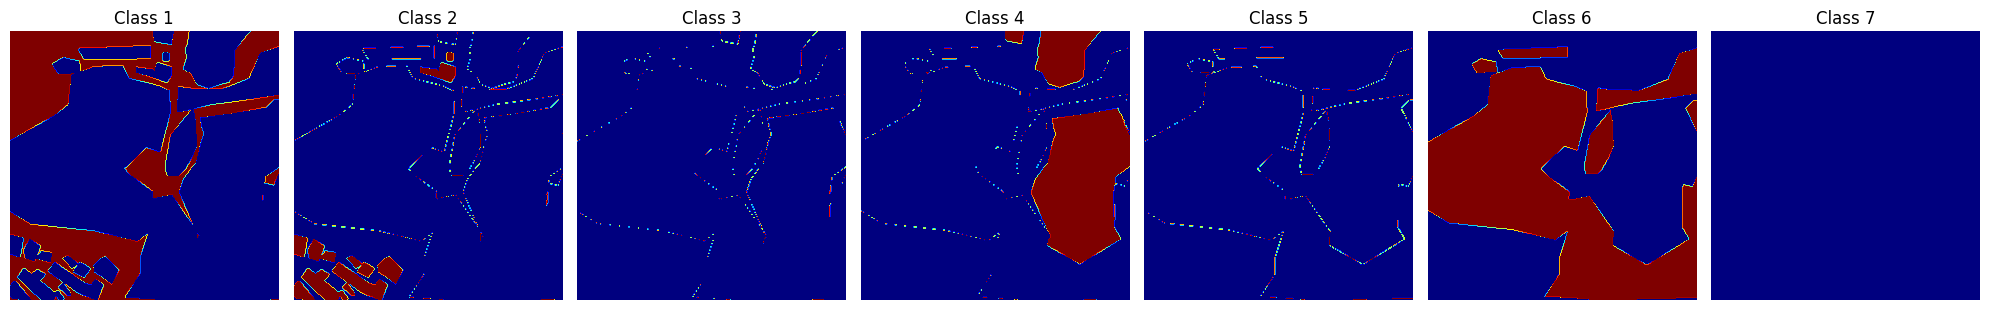

In [51]:
# Ensure the model is on the correct device (GPU or CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)  # Move model to the selected device
torch.cuda.empty_cache()
TRAINING=1
if TRAINING:  # Ensure you have a condition for training mode
    # Pick a random batch from the train loader
    a, b = train_dataset[104]
    inputs, targets = a, b  # Assuming the loader returns (input, target) pairs

    # Move the inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.unsqueeze(0)  # Add a batch dimension

    # Get the model output for the input
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():
        output = model(inputs)  # Get model prediction for the input

    # Print the random input, output, and ground truth
    print("\nRandom Sample (Epoch {})".format(i))
    print("Input Tensor: ", inputs.shape)
    print("Ground Truth: ", targets.shape)
    print("Model Output: ", output.shape)
    output = output.squeeze(0)
    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = output[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = targets[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    model.train()

In [54]:
import time
from thop import profile, clever_format #used at the end
# Performance Evaluation (Latency, FLOPs, and Parameters)
print("\nEvaluating Model Performance:")

# Measure latency
dummy_input = torch.randn(1, 3, 256, 256).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    model(dummy_input)
    end_time = time.time()
latency = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Latency: {latency:.2f} ms")

# Compute FLOPs and Params
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}")
print(f"Params: {params}")


Evaluating Model Performance:
Latency: 41.85 ms
FLOPs: 11.535G
Params: 62.231M


In [53]:
!pip install thop

In [ ]:
model = DeepLabV2(num_classes=NUM_CLASSES).to(device)

# Assuming your model class is DeepLabV2 and the model is saved as 'deeplabv2_model.pth'
model = DeepLabV2(num_classes=NUM_CLASSES).to(device)  # Initialize an instance of your model
load_path = "/content/drive/MyDrive/deeplabv2_model.pth"  # Update with your model's path on Drive

try:
    model.load_state_dict(torch.load(load_path))
    print(f"Model loaded from {load_path}")
except Exception as e:
    print("Failed to load the model. Check the provided path and model class.")
    print(e)

<ipython-input-49-624d5fffd320>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


Model loaded from /content/drive/MyDrive/deeplabv2_model.pth


In [ ]:
try:
    save_path = "/content/drive/MyDrive/deeplabv2_model.pth"  # Update with your desired path on Drive
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
except Exception as e:
    print("Failed to save model. Check your output path.")
    print(e)

Model saved to /content/drive/MyDrive/deeplabv2_model.pth
